In [22]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, RepeatedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)
os.chdir('E:/数据竞赛/津南/competition-0119')

In [2]:
train = pd.read_csv('jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [3]:
#训练集数据缺失统计
stats_train = []
for col in train.columns:
    stats_train.append((col,
                        train[col].nunique(),
                        train[col].isnull().sum() * 100 / train.shape[0],
                        train[col].value_counts(normalize=True, dropna=False).values[0],
                        train[col].value_counts(normalize=True, dropna=False).values[1],
                        train[col].dtype))
    
stats_train = pd.DataFrame(stats_train, columns=['Feature', 'Unique_values', 'Percentage of missing values', 
                                                 'Percentage of values in the biggest category', 'Percentage_second','type'])
stats_train.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,Percentage_second,type
2,A2,1,96.991404,0.969914,0.030086,float64
7,A7,75,89.326648,0.893266,0.009312,object
8,A8,8,89.326648,0.893266,0.084527,float64
39,B11,37,60.816619,0.608166,0.110315,object
38,B10,180,17.478510,0.174785,0.118911,object
3,A3,3,3.008596,0.957020,0.030086,float64
29,B1,21,0.716332,0.537966,0.090974,float64
23,A23,3,0.214900,0.996418,0.002149,float64
21,A21,12,0.214900,0.898281,0.045129,float64
30,B2,3,0.143266,0.984241,0.013610,float64


In [4]:
#测试集数据缺失统计
stats_test = []
for col in test.columns:
    stats_test.append((col,
                        train[col].nunique(),
                        train[col].isnull().sum() * 100 / train.shape[0],
                        train[col].value_counts(normalize=True, dropna=False).values[0],
                        train[col].value_counts(normalize=True, dropna=False).values[1],
                        train[col].dtype))
    
stats_test = pd.DataFrame(stats_test, columns=['Feature', 'Unique_values', 'Percentage of missing values', 
                                                 'Percentage of values in the biggest category', 'Percentage_second','type'])
stats_test.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,Percentage_second,type
2,A2,1,96.991404,0.969914,0.030086,float64
8,A8,8,89.326648,0.893266,0.084527,float64
7,A7,75,89.326648,0.893266,0.009312,object
39,B11,37,60.816619,0.608166,0.110315,object
38,B10,180,17.478510,0.174785,0.118911,object
3,A3,3,3.008596,0.957020,0.030086,float64
29,B1,21,0.716332,0.537966,0.090974,float64
21,A21,12,0.214900,0.898281,0.045129,float64
23,A23,3,0.214900,0.996418,0.002149,float64
31,B3,2,0.143266,0.997851,0.001433,float64


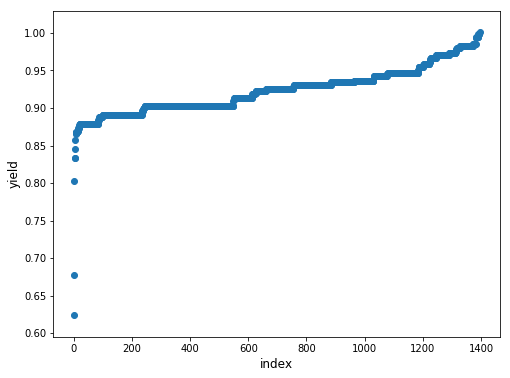

In [5]:
#查看收率取值情况 ，几乎都>0.87
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['收率'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

In [6]:
good_cols = list(train.columns)

# 删除类别唯一的特征
only_tr = list(stats_train[stats_train.Unique_values == 1]['Feature'])
only_te = list(stats_test[stats_test.Unique_values == 1]['Feature'])
only_f = [i for i in only_tr if i in only_te]
for i in only_f:
    good_cols.remove(i)

# 删除缺失率超过85%的列
miss_tr = list(stats_train[stats_train['Percentage of missing values']>0.85]['Feature'])
miss_te = list(stats_test[stats_test['Percentage of missing values']>0.85]['Feature'])
miss_f = [i for i in miss_tr if i in miss_te]
try:
    for i in miss_f :
        good_cols = good_cols.remove(i)
except :
    print('已经删除')

train = train[train['收率']>0.87]
train = train[train['样本id'] != 'sample_1590'] #sample_1590样本数据有问题
    
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

已经删除


In [8]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)
data.head()

,样本id,A1,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14
0,sample_1528,300,405.0,700,13:30:00,38.0,-1,-1.0,15:30:00,100,16:30:00,102.0,0.2,17:30:00,103.0,18:30:00,104.0,0.2,300,21:00-21:30,50.0,9.0,5.0,22:00:00,75,22:30:00,70.0,6:30-7:00,350.0,3.5,3.5,7:00-8:00,8:00:00,65,11:30:00,45.0,11:30-13:00,14:00-15:30,-1,800.0,0.15,400
1,sample_1698,300,405.0,700,14:00:00,29.0,-1,-1.0,16:00:00,101,17:00:00,103.0,0.2,18:00:00,104.0,19:00:00,105.0,0.2,200,19:00-20:00,50.0,9.0,5.0,20:00:00,80,21:00:00,73.0,21:00-22:00,320.0,3.5,3.5,22:00-23:00,23:00:00,80,6:00:00,45.0,6:00-7:30,7:30-9:00,9:00-10:00,1200.0,0.15,400
2,sample_639,300,405.0,700,14:00:00,29.0,-1,-1.0,16:00:00,102,17:00:00,103.0,0.2,18:00:00,104.0,19:00:00,105.0,0.2,200,19:00-19:30,50.0,9.0,5.0,20:00:00,79,21:00:00,73.0,21:00-22:00,320.0,3.5,3.5,22:00-23:00,23:00:00,80,1:00:00,45.0,1:00-2:30,2:30-4:00,4:00-5:00,1200.0,0.15,400
3,sample_483,300,405.0,700,1:30:00,38.0,-1,-1.0,3:00:00,100,4:00:00,102.0,0.2,5:00:00,103.0,6:00:00,104.0,0.2,200,6:30-7:00,50.0,10.0,5.0,7:30:00,70,8:00:00,78.0,13:30-14:30,290.0,3.5,3.5,14:30-15:30,15:30:00,65,18:00:00,45.0,19:00-20:30,21:30-23:00,-1,800.0,0.15,400
4,sample_617,300,405.0,700,22:00:00,29.0,-1,-1.0,0:00:00,101,1:00:00,103.0,0.2,2:00:00,104.0,3:00:00,105.0,0.2,200,3:00-4:00,50.0,9.0,5.0,4:00:00,80,5:00:00,73.0,5:00-6:00,320.0,3.5,3.5,6:00-7:00,7:00:00,80,9:00:00,45.0,9:00-10:30,10:30-12:00,12:00-13:00,1200.0,0.15,420


In [9]:
#时间间隔转换
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)
    
data.head()

,样本id,A1,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14
0,sample_1528,300,405.0,700,13.5,38.0,-1.0,-1.0,15.5,100,16.5,102.0,0.2,17.5,103.0,18.5,104.0,0.2,300,0.5,50.0,9.0,5.0,22.0,75,22.5,70.0,0.5,350.0,3.5,3.5,1.0,8.0,65,11.5,45.0,1.5,1.5,-1.0,800.0,0.15,400
1,sample_1698,300,405.0,700,14.0,29.0,-1.0,-1.0,16.0,101,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,1.0,50.0,9.0,5.0,20.0,80,21.0,73.0,1.0,320.0,3.5,3.5,1.0,23.0,80,6.0,45.0,1.5,1.5,1.0,1200.0,0.15,400
2,sample_639,300,405.0,700,14.0,29.0,-1.0,-1.0,16.0,102,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,0.5,50.0,9.0,5.0,20.0,79,21.0,73.0,1.0,320.0,3.5,3.5,1.0,23.0,80,1.0,45.0,1.5,1.5,1.0,1200.0,0.15,400
3,sample_483,300,405.0,700,1.5,38.0,-1.0,-1.0,3.0,100,4.0,102.0,0.2,5.0,103.0,6.0,104.0,0.2,200,0.5,50.0,10.0,5.0,7.5,70,8.0,78.0,1.0,290.0,3.5,3.5,1.0,15.5,65,18.0,45.0,1.5,1.5,-1.0,800.0,0.15,400
4,sample_617,300,405.0,700,22.0,29.0,-1.0,-1.0,0.0,101,1.0,103.0,0.2,2.0,104.0,3.0,105.0,0.2,200,1.0,50.0,9.0,5.0,4.0,80,5.0,73.0,1.0,320.0,3.5,3.5,1.0,7.0,80,9.0,45.0,1.5,1.5,1.0,1200.0,0.15,420


In [13]:
cate_columns = [f for f in data.columns if f != '样本id']
#把连续性变量转换成数据的位次（秩）
for f in cate_columns:
    data[f] = data[f].map(float)
    data[f] = data[f].map(dict(zip(list(np.unique(data[f])), range(0, data[f].nunique()))))
data.head()

,样本id,A1,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14
0,sample_1528,2,3,2,38,22,0,0,60,0,64,3,2,69,3,73,9,1,3,4,7,2,2,87,5,85,3,1,17,2,1,3,21,20,27,18,5,8,0,2,2,13
1,sample_1698,2,3,2,40,13,0,0,62,1,66,4,2,71,6,75,10,1,2,7,7,2,2,79,10,79,6,6,14,2,1,3,60,35,14,18,5,8,2,4,2,13
2,sample_639,2,3,2,40,13,0,0,62,2,66,4,2,71,6,75,10,1,2,4,7,2,2,79,9,79,6,6,14,2,1,3,60,35,2,18,5,8,2,4,2,13
3,sample_483,2,3,2,3,22,0,0,7,0,12,3,2,17,3,21,9,1,2,4,7,3,2,28,1,29,11,6,10,2,1,3,40,20,46,18,5,8,0,2,2,13
4,sample_617,2,3,2,60,13,0,0,0,1,5,4,2,10,6,14,10,1,2,7,7,2,2,18,10,20,6,6,14,2,1,3,17,35,22,18,5,8,2,4,2,16


In [14]:
#还原训练集和测试集
train = data[:train.shape[0]]
test  = data[train.shape[0]:]

In [15]:
train['target'] = target
#target离散化，分成5个区间
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
#get_dummies
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']

mean_features = []
for f1 in cate_columns:
    #每一个自变量出现最多的值
    rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    #如果出现最多的值的频率小于0.5，分别统计他们对应target分组的平均值
    if rate < 0.50:
        for f2 in li:
            col_name = f1+"_"+f2+'_mean'
            mean_features.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            for df in [train, test]:
                df[col_name] = df[f1].map(order_label)

train.drop(li, axis=1, inplace=True)

In [16]:
train['样本id'] = [(float(i.strip('sample_'))-1000)/1000 for i in train['样本id']]
train.drop(['target'], axis=1, inplace=True)
test = test[train.columns]
test['样本id'] = [(float(i.strip('sample_'))-1000)/1000 for i in test['样本id']]
X_train = train.values
y_train = target.values
X_test = test.values
print(X_train.shape)
print(X_test.shape)

(1380, 122)
(150, 122)


In [17]:
##### xgboost
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422991	valid_data-rmse:0.42355
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.257055	valid_data-rmse:0.257481
[200]	train-rmse:0.156683	valid_data-rmse:0.156998
[300]	train-rmse:0.096115	valid_data-rmse:0.096276
[400]	train-rmse:0.059622	valid_data-rmse:0.059776
[500]	train-rmse:0.037627	valid_data-rmse:0.038073
[600]	train-rmse:0.024414	valid_data-rmse:0.025479
[700]	train-rmse:0.016427	valid_data-rmse:0.01837
[800]	train-rmse:0.011653	valid_data-rmse:0.014658
[900]	train-rmse:0.008775	valid_data-rmse:0.012795
[1000]	train-rmse:0.007095	valid_data-rmse:0.011952
[1100]	train-rmse:0.006039	valid_data-rmse:0.011567
[1200]	train-rmse:0.005327	valid_data-rmse:0.011384
[1300]	train-rmse:0.004819	valid_data-rmse:0.011305
[1400]	train-rmse:0.004384	valid_data-rmse:0.011262
[1500]	train-rmse:0.004053	valid_data-rmse:0.011248
[1600]	train-rmse

In [20]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=4096)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
        val_data = lgb.Dataset(X[val_idx], y[val_idx])

        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_preds[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)

    score = mean_squared_error(oof_preds, target)
    
    return  score/2

In [23]:
#特征选择
def featureSelect(init_cols):
    params = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.05,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.02,
             "verbosity": -1}
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        print('-'*10)
        if diff > 0.0000002:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！".format(f,score,best_score))
            best_score = score
        else:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 没效果,保留！！".format(f,score,best_score))
            best_cols.append(f)
    print('-'*10)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols
    
best_features = featureSelect(train.columns.tolist())

fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[138]	training's l2: 6.65421e-05	valid_1's l2: 0.000161851
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[144]	training's l2: 6.14514e-05	valid_1's l2: 0.000162881
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[269]	training's l2: 4.68296e-05	valid_1's l2: 0.000146215
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[186]	training's l2: 5.90405e-05	valid_1's l2: 0.000152461
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[450]	training's l2: 3.25159e-05	valid_1's l2: 0.000175012
初始CV score: 0.00007984
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[193]	training's l2: 9.93122e-05	valid_1

Early stopping, best iteration is:
[144]	training's l2: 6.05317e-05	valid_1's l2: 0.000161944
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[337]	training's l2: 4.0159e-05	valid_1's l2: 0.000147126
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	training's l2: 5.96114e-05	valid_1's l2: 0.000150039
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[309]	training's l2: 4.12712e-05	valid_1's l2: 0.000178907
----------
当前移除特征: A9, CV score: 0.00007974, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[128]	training's l2: 6.88619e-05	valid_1's l2: 0.00015964
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[141]	training's l2: 6.36587e-05	valid_1's l2: 0.000159729


Early stopping, best iteration is:
[212]	training's l2: 5.5272e-05	valid_1's l2: 0.000149735
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[173]	training's l2: 6.20254e-05	valid_1's l2: 0.000149152
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[328]	training's l2: 3.9269e-05	valid_1's l2: 0.000180571
----------
当前移除特征: A18, CV score: 0.00008073, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[132]	training's l2: 6.747e-05	valid_1's l2: 0.000160824
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[153]	training's l2: 5.85896e-05	valid_1's l2: 0.000160651
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[344]	training's l2: 4.0107e-05	valid_1's l2: 0.000147224
fo

Early stopping, best iteration is:
[172]	training's l2: 6.33616e-05	valid_1's l2: 0.000151496
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[450]	training's l2: 3.2718e-05	valid_1's l2: 0.000180204
----------
当前移除特征: A27, CV score: 0.00007974, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[132]	training's l2: 6.81477e-05	valid_1's l2: 0.000160983
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[143]	training's l2: 6.10725e-05	valid_1's l2: 0.000156717
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	training's l2: 5.14875e-05	valid_1's l2: 0.000147566
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	training's l2: 6.25463e-05	valid_1's l2: 0.00014942

Early stopping, best iteration is:
[462]	training's l2: 3.14631e-05	valid_1's l2: 0.000175819
----------
当前移除特征: B8, CV score: 0.00007940, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[202]	training's l2: 4.92735e-05	valid_1's l2: 0.000161142
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[214]	training's l2: 4.5448e-05	valid_1's l2: 0.000163332
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[281]	training's l2: 4.63412e-05	valid_1's l2: 0.000147056
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[188]	training's l2: 5.86245e-05	valid_1's l2: 0.000147148
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[391]	training's l2: 3.52548e-05	valid_1's l2: 0.000179672

Early stopping, best iteration is:
[452]	training's l2: 3.23316e-05	valid_1's l2: 0.000175089
----------
当前移除特征: A5_intTarget_2.0_mean, CV score: 0.00007899, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	training's l2: 6.61302e-05	valid_1's l2: 0.000161614
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[200]	training's l2: 4.84132e-05	valid_1's l2: 0.000158752
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[329]	training's l2: 4.02928e-05	valid_1's l2: 0.000145097
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[158]	training's l2: 6.63046e-05	valid_1's l2: 0.000150912
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[445]	training's l2: 3.25454e-05	valid

Early stopping, best iteration is:
[432]	training's l2: 3.32884e-05	valid_1's l2: 0.00017487
----------
当前移除特征: A9_intTarget_1.0_mean, CV score: 0.00007912, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[132]	training's l2: 6.9013e-05	valid_1's l2: 0.000161714
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[153]	training's l2: 5.871e-05	valid_1's l2: 0.000161166
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[233]	training's l2: 5.26307e-05	valid_1's l2: 0.000149638
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	training's l2: 5.9417e-05	valid_1's l2: 0.000151428
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[439]	training's l2: 3.29898e-05	valid_1's 

Early stopping, best iteration is:
[436]	training's l2: 3.3221e-05	valid_1's l2: 0.000179839
----------
当前移除特征: A11_intTarget_0.0_mean, CV score: 0.00007899, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[128]	training's l2: 6.81234e-05	valid_1's l2: 0.00015978
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[186]	training's l2: 5.01899e-05	valid_1's l2: 0.000160678
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[289]	training's l2: 4.53305e-05	valid_1's l2: 0.000149597
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	training's l2: 5.98253e-05	valid_1's l2: 0.000151205
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[429]	training's l2: 3.33877e-05	valid_

Early stopping, best iteration is:
[450]	training's l2: 3.30535e-05	valid_1's l2: 0.000177974
----------
当前移除特征: A12_intTarget_4.0_mean, CV score: 0.00007927, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[120]	training's l2: 7.14895e-05	valid_1's l2: 0.000157878
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[175]	training's l2: 5.23203e-05	valid_1's l2: 0.000159536
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[385]	training's l2: 3.62362e-05	valid_1's l2: 0.00014943
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[180]	training's l2: 6.02584e-05	valid_1's l2: 0.000152595
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[759]	training's l2: 2.44363e-05	valid

Early stopping, best iteration is:
[450]	training's l2: 3.26354e-05	valid_1's l2: 0.000181321
----------
当前移除特征: A16_intTarget_3.0_mean, CV score: 0.00007941, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	training's l2: 6.50991e-05	valid_1's l2: 0.000158215
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[214]	training's l2: 4.52252e-05	valid_1's l2: 0.000158453
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[231]	training's l2: 5.19194e-05	valid_1's l2: 0.00014465
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	training's l2: 6.02634e-05	valid_1's l2: 0.000152559
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[478]	training's l2: 3.14668e-05	valid

Early stopping, best iteration is:
[614]	training's l2: 2.73784e-05	valid_1's l2: 0.000176822
----------
当前移除特征: A24_intTarget_2.0_mean, CV score: 0.00007943, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	training's l2: 6.42112e-05	valid_1's l2: 0.000160273
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	training's l2: 5.08595e-05	valid_1's l2: 0.000160732
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[336]	training's l2: 3.98863e-05	valid_1's l2: 0.00014594
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[175]	training's l2: 6.19424e-05	valid_1's l2: 0.000152576
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[477]	training's l2: 3.11104e-05	valid

Early stopping, best iteration is:
[456]	training's l2: 3.20843e-05	valid_1's l2: 0.000181657
----------
当前移除特征: A26_intTarget_1.0_mean, CV score: 0.00008105, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 5.01413e-05	valid_1's l2: 0.000165511
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[173]	training's l2: 5.37336e-05	valid_1's l2: 0.000158688
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[319]	training's l2: 4.24053e-05	valid_1's l2: 0.000147793
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	training's l2: 6.162e-05	valid_1's l2: 0.000150154
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[448]	training's l2: 3.24387e-05	valid_

Early stopping, best iteration is:
[440]	training's l2: 3.26853e-05	valid_1's l2: 0.000181322
----------
当前移除特征: B5_intTarget_0.0_mean, CV score: 0.00007987, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[119]	training's l2: 7.19899e-05	valid_1's l2: 0.000155344
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[178]	training's l2: 5.28764e-05	valid_1's l2: 0.000160737
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[520]	training's l2: 3.01331e-05	valid_1's l2: 0.000147154
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[173]	training's l2: 6.22576e-05	valid_1's l2: 0.000152146
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[386]	training's l2: 3.57246e-05	valid

Early stopping, best iteration is:
[447]	training's l2: 3.28749e-05	valid_1's l2: 0.000180628
----------
当前移除特征: B6_intTarget_4.0_mean, CV score: 0.00007979, 最佳cv score: 0.00007864, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[188]	training's l2: 5.27035e-05	valid_1's l2: 0.000163083
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[227]	training's l2: 4.41732e-05	valid_1's l2: 0.000161758
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[227]	training's l2: 5.28508e-05	valid_1's l2: 0.00014938
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	training's l2: 6.33205e-05	valid_1's l2: 0.000148785
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[456]	training's l2: 3.2427e-05	valid_1

In [24]:
best_features

['样本id',
 'A4',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A16',
 'A17',
 'A18',
 'A19',
 'A20',
 'A21',
 'A22',
 'A23',
 'A24',
 'A25',
 'A26',
 'A27',
 'A28',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'B12',
 'B13',
 'B14',
 'A5_intTarget_0.0_mean',
 'A5_intTarget_1.0_mean',
 'A5_intTarget_2.0_mean',
 'A5_intTarget_3.0_mean',
 'A5_intTarget_4.0_mean',
 'A6_intTarget_0.0_mean',
 'A6_intTarget_1.0_mean',
 'A6_intTarget_2.0_mean',
 'A6_intTarget_3.0_mean',
 'A6_intTarget_4.0_mean',
 'A9_intTarget_0.0_mean',
 'A9_intTarget_1.0_mean',
 'A9_intTarget_2.0_mean',
 'A9_intTarget_3.0_mean',
 'A9_intTarget_4.0_mean',
 'A10_intTarget_0.0_mean',
 'A10_intTarget_1.0_mean',
 'A10_intTarget_2.0_mean',
 'A10_intTarget_3.0_mean',
 'A10_intTarget_4.0_mean',
 'A11_intTarget_0.0_mean',
 'A11_intTarget_1.0_mean',
 'A11_intTarget_2.0_mean',
 'A11_intTarget_3.0_mean',
 'A11_intTarget_4.0_mean',
 'A12_intTarget_0.0_mean',
 'A12_intTarge

In [25]:
train_best = train[best_features].values
test_best = test[best_features].values
#数据导出
np.save('X_train.npy',train_best)
np.save('X_test.npy',test_best)
np.save('y_train.npy',y_train)